# Майнор "Интеллектуальный анализ данных"

# Курс "Прикладные задачи анализа данных"

## Лабораторная работа №2. RecSys

В рамках данной лабораторной работы вам предлагается решить задачу рекомендательной системы на основе следующих данных:

* **rating.csv** - рейтинги аниме по 10 бальной шкале
* **anime.csv** - описание items

Скачать данные можно [здесь](https://drive.google.com/drive/u/1/folders/1FarHUuqQq4tQSlERB9K8uEfZAZT9tQWv)

# Данные

Данные содержат информацию об предподчтениях 73,516 пользователей в 12,294 аниме. Каждый пользователь может добавить аниме и выставить рейтниг.

Anime.csv

* anime_id - идентификатор аниме (items)
* name - полное название аниме
* genre - категория/категории для аниме (разделены запятой).
* type - тип: movie, TV, OVA, etc.
* episodes - количество эпизодов (для экранизаций)
* rating - средний рейтинг по аниме.
* members - количество членов коммьюнити к аниме

Rating.csv

* user_id - идентификатор пользователя (users)
* anime_id - идентификатор аниме
* rating - рейтинг пользователя по аниме (-1 пользователь смотрел, но не оставил рейтинг).

### ``` Если вычеслительные ресурсы не позволяют решить задачу на всех данных, то необходимо это сделать на "сэмпле" данных (выбрав от 5% ids' для user и item). Этот же подход справедлив и для оценки работы алгоритомв```

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import urllib.request
from urllib.error import HTTPError

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_an = pd.read_csv("./drive/MyDrive/Colab Notebooks/Lab2/anime.csv", index_col=None)

In [ ]:
df_rat = pd.read_csv("./drive/MyDrive/Colab Notebooks/Lab2/rating.csv", index_col=None)

## Необходимо сделать:

### Задание №1 : Exploratory analysis (2 балла):

* Распределение числа пользователей по количеству взаимодействий
* Разпределение числа "айтемов" по количеству взаимодействий
* Распределение числа рейтингов, средних рейтингов по пользователям, по "айтемам"
* и т.д. (бонус)

In [ ]:
df_an.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
df_rat.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [ ]:
df_an.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Видим, что пропусков мало в сравнении с объемом данных, поэтому заполним средним или часто встречающимся значениями.

In [ ]:
df_an['genre'].mode() #самый частый жанр

0    Hentai
dtype: object

In [ ]:
df_an.loc[df_an['genre'].isna(), 'genre'] = 'Hentai'

In [ ]:
df_an['type'].mode() #самый частый тип аниме

0    TV
dtype: object

In [ ]:
df_an.loc[df_an['type'].isna(), 'type'] = 'TV'

In [ ]:
df_an.loc[df_an['rating'].isna(),'rating'] = df_an['rating'].mean()

In [ ]:
df_an.loc[df_an['episodes'] == 'Unknown', 'episodes'] = 0

In [ ]:
df_an['episodes'] = pd.to_numeric(df_an['episodes'])

In [ ]:
df_an.loc[df_an['episodes'] == 0, 'episodes'] = round(df_an['episodes'].mean(),0)

In [ ]:
df_an.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [ ]:
df_an.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12294 non-null  object 
 3   type      12294 non-null  object 
 4   episodes  12294 non-null  int64  
 5   rating    12294 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 672.5+ KB


Все данные приведены к нужным форматам. Начнем первичный анализ

In [ ]:
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.hist(dataset[attribute], bins=bins, color=bar_color, ec=edge_color, linewidth=2)
    
    plt.xticks(rotation=45)

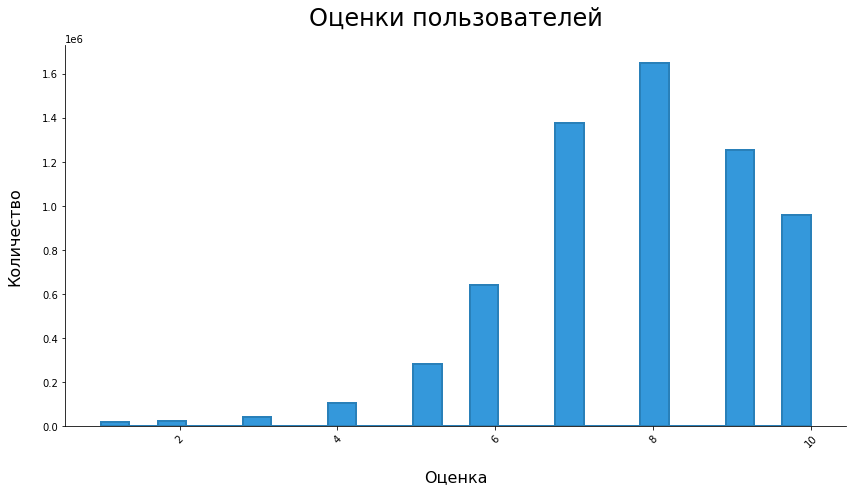

In [ ]:
make_histogram(df_rat[df_rat['rating'] != -1], 'rating', title='Оценки пользователей', xlab='Оценка', ylab='Количество')

In [ ]:
top_inter = df_rat[df_rat['rating'] != -1].pivot_table(['rating'],['anime_id'],aggfunc= ['mean','count']).sort_values([('count','rating')], ascending=False)

In [ ]:
top_names = top_inter.merge(df_an, on='anime_id')

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [ ]:
top_names.head(10)

,anime_id,"(mean, rating)","(count, rating)",name,genre,type,episodes,rating,members
0,1535,8.834629,34226,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
1,11757,8.140213,26310,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
2,16498,8.725741,25290,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
3,1575,8.927796,24126,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
4,6547,8.549714,23565,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
5,226,8.064434,23528,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511
6,20,7.893888,22071,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
7,5114,9.322741,21494,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
8,121,8.453356,21332,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,51,8.33,600384
9,2904,9.059837,21124,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888


In [ ]:
top_names[('count', 'rating')].describe()

count     9926.000000
mean       638.448418
std       1795.944649
min          1.000000
25%          9.000000
50%         57.000000
75%        395.000000
max      34226.000000
Name: (count, rating), dtype: float64

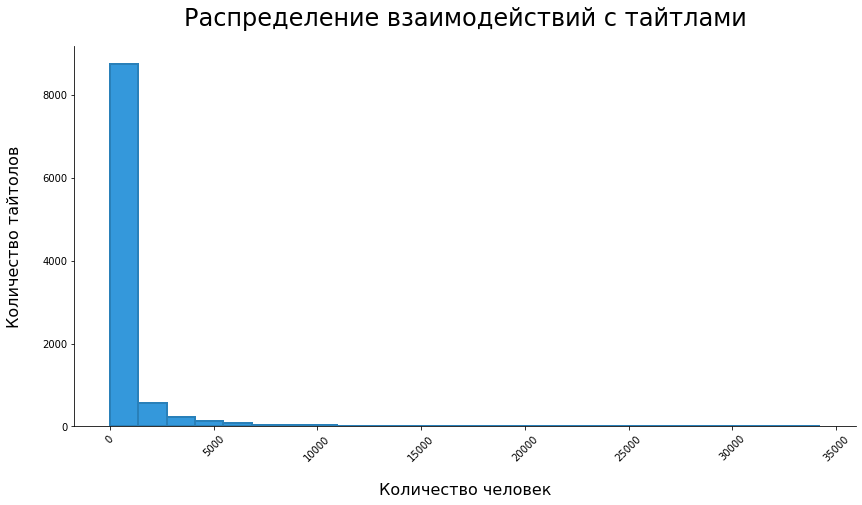

In [ ]:
make_histogram(top_names, ('count', 'rating'), title='Распределение взаимодействий с тайтлами', xlab='Количество человек', ylab='Количество тайтолов')

50% тайтлов имеют 57 и менее взаимодействий (выставление оценки), 75% тайтлов имеют 395 и менее взаимодействий (выставление оценки). Хоть среднее взаимодействие 638, но это лишь благодаря единицам аниме, с высоким количеством взаимодействий.

In [ ]:
top_user_withpu_minus1 = df_rat[df_rat['rating'] != -1].pivot_table(['rating'],['user_id'],aggfunc= ['mean','count']).sort_values([('count','rating')], ascending=False)
top_user_interaction = df_rat.pivot_table(['rating'],['user_id'],aggfunc= ['mean','count']).sort_values([('count','rating')], ascending=False)

In [ ]:
top_user_interaction

,mean,count
,rating,rating
user_id,,
48766,-1.000000,10227
42635,6.354951,3747
53698,6.546644,2905
57620,7.921170,2702
59643,7.040638,2633
...,...,...
11323,10.000000,1
48775,-1.000000,1


In [ ]:
top_user_withpu_minus1

,mean,count
,rating,rating
user_id,,
42635,6.354951,3747
53698,6.546644,2905
57620,7.964299,2689
59643,7.043693,2632
51693,6.594811,2621
...,...,...
66747,7.000000,1
35463,9.000000,1


In [ ]:
top_user_interaction[('count', 'rating')].describe()

count    73515.000000
mean       106.287656
std        153.086558
min          1.000000
25%         18.000000
50%         57.000000
75%        136.000000
max      10227.000000
Name: (count, rating), dtype: float64

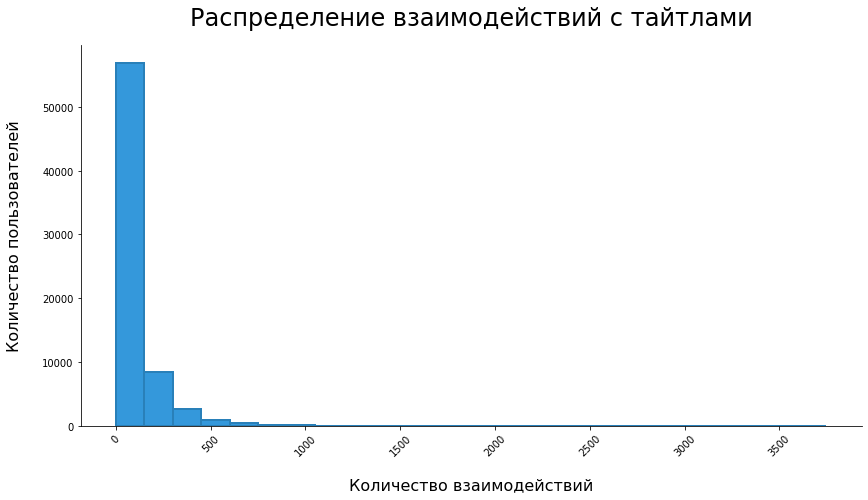

In [ ]:
make_histogram(top_user_withpu_minus1, ('count', 'rating'), title='Распределение взаимодействий с тайтлами', xlab='Количество взаимодействий', ylab='Количество пользователей')

50% пользователй посмотрело хот бы 57 тайтлов, но среднее количество просмотренных составляет 106

### Задание №2 : Оценить разреженность данных по рейтингу (1/2 балла)

In [ ]:
df_rat[df_rat['rating'] != -1]['rating'].describe()

count    6.337241e+06
mean     7.808497e+00
std      1.572496e+00
min      1.000000e+00
25%      7.000000e+00
50%      8.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [ ]:
len(df_rat[df_rat['rating'] == -1])/len(df_rat)

0.18896156858107716

In [ ]:
3915/len(df_rat['user_id'].unique())

0.05325443786982249

Рейтинги в хорошем виде, хоть и довольно большое количество людей не ставят оценки. Видно смещение средней оценки к 8. Пользователи более склонны оценивать высоко. Нормализировать оценки не будем.
19% людей не поставили оценки после просмотра.
3915 людей никогда не ставили оценки (примерно 5%).

### Задание №3 : Разделить данные на тренировочные и валидационные (1/2 балла)

In [ ]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(df_rat,test_size = 0.20, random_state=52)

In [ ]:
train.shape

(6250989, 3)

In [ ]:
test.shape

(1562748, 3)

### Задание №4 : Решить задачу на основе предложения всем юзерам наиболее популярных item (1 балл)

In [324]:
def mean_reciprocal_rank(rs):
    """Score is reciprocal of the rank of the first relevant item
    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).
    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean reciprocal rank
    """
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])


def r_precision(r):
    """Score is precision after all relevant documents have been retrieved
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> r_precision(r)
    0.33333333333333331
    >>> r = [0, 1, 0]
    >>> r_precision(r)
    0.5
    >>> r = [1, 0, 0]
    >>> r_precision(r)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        R Precision
    """
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])


def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
    >>> mean_average_precision(rs)
    0.78333333333333333
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
    >>> mean_average_precision(rs)
    0.39166666666666666
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [367]:
list(train.groupby('anime_id')['rating'].mean().reset_index().sort_values(by='rating', ascending=False)['anime_id'][:20].values)

[31211,
 6630,
 30743,
 33484,
 25079,
 34252,
 20235,
 5535,
 31972,
 30939,
 9959,
 27653,
 30484,
 32281,
 820,
 9253,
 5114,
 7461,
 31238,
 31111]

In [368]:
ranking_table['most_popular'] = 1

NameError: ignored

In [ ]:
high20 = list(top_names['anime_id'].head(20))

In [ ]:
top_names.head(20)

,anime_id,"(mean, rating)","(count, rating)",name,genre,type,episodes,rating,members
0,1535,8.834629,34226,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
1,11757,8.140213,26310,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
2,16498,8.725741,25290,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
3,1575,8.927796,24126,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
4,6547,8.549714,23565,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
5,226,8.064434,23528,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511
6,20,7.893888,22071,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
7,5114,9.322741,21494,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
8,121,8.453356,21332,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,51,8.33,600384
9,2904,9.059837,21124,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888


In [ ]:
high20

[1535,
 11757,
 16498,
 1575,
 6547,
 226,
 20,
 5114,
 121,
 2904,
 4224,
 8074,
 199,
 2167,
 10620,
 9919,
 9253,
 11111,
 2001,
 3588]

In [ ]:
for user in train['user_id'].unique():
  for high in high20:
    if len(train[train['user_id']==user].loc[train['anime_id']==high]) == 0:
      train.loc[train['user_id']==user, 'rec_pop'] = high
      break

Выходные данные были обрезаны до нескольких последних строк (5000).
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/li

In [ ]:
rat = train[~train['rec_pop'].isna()]

In [ ]:
rat_w = rat.drop_duplicates('user_id').drop(columns = ['anime_id']).rename(columns = {'rec_pop':'anime_id'}).merge(df_an, on = 'anime_id')

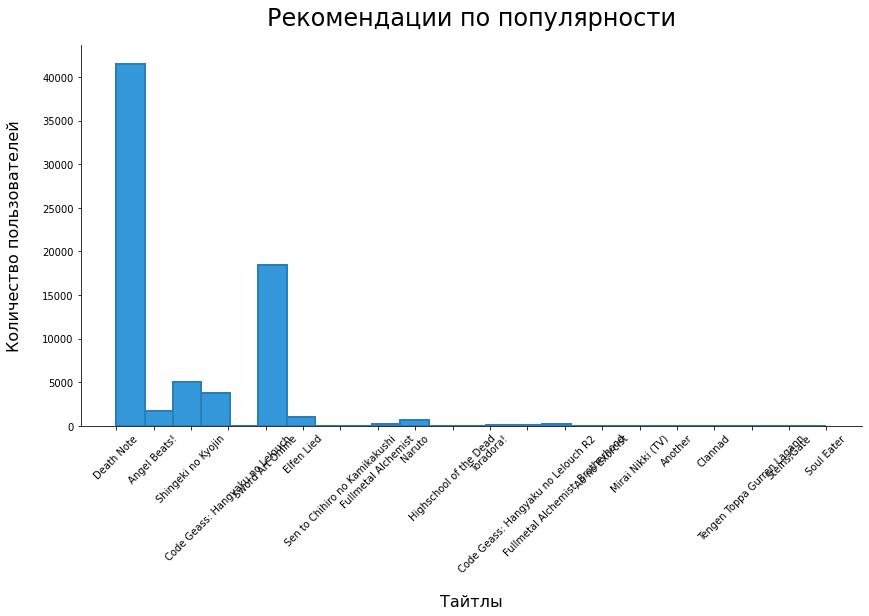

In [ ]:
make_histogram(rat_w, 'name', title='Рекомендации по популярности', xlab='Тайтлы', ylab='Количество пользователей')

In [ ]:
rat_w.name.value_counts()

Death Note                            41544
Sword Art Online                      18401
Shingeki no Kyojin                     5083
Code Geass: Hangyaku no Lelouch        3817
Angel Beats!                           1716
Elfen Lied                             1053
Naruto                                  669
Fullmetal Alchemist: Brotherhood        235
Fullmetal Alchemist                     187
Toradora!                                95
Code Geass: Hangyaku no Lelouch R2       65
Sen to Chihiro no Kamikakushi            38
Highschool of the Dead                   36
Clannad                                  12
Mirai Nikki (TV)                          6
Ao no Exorcist                            5
Another                                   4
Soul Eater                                4
Steins;Gate                               3
Tengen Toppa Gurren Lagann                3
Name: name, dtype: int64

Посмотрим, как хорошо будет предсказывать модель, которая рекомендует топ-20 аниме

In [371]:
rank_table = df_rat.groupby(['user_id'])['anime_id'].apply(lambda x: list(x)).to_frame().reset_index()

In [372]:
rank_table['most_popular'] = 1

In [380]:
rank_table['most_popular'] = rank_table['most_popular'].map(lambda x: high20)

In [381]:
rank_table.head()

,user_id,anime_id,most_popular
0,1,"[20, 24, 79, 226, 241, 355, 356, 442, 487, 846...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114..."
1,2,"[11771, 12189, 16417]","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114..."
2,3,"[20, 154, 170, 199, 225, 341, 430, 527, 552, 8...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114..."
3,4,"[6, 72, 121, 150, 166, 205, 226, 857, 1292, 14...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114..."
4,5,"[6, 15, 17, 18, 20, 22, 24, 30, 45, 47, 57, 63...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114..."


In [382]:
rank_table['top_20_mp'] = rank_table.apply(lambda x: [int(pred in x['anime_id'][:20]) for pred in x['most_popular'][:20]], axis=1)

In [383]:
rank_table

,user_id,anime_id,most_popular,top_20_mp
0,1,"[20, 24, 79, 226, 241, 355, 356, 442, 487, 846...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[11771, 12189, 16417]","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"[20, 154, 170, 199, 225, 341, 430, 527, 552, 8...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,4,"[6, 72, 121, 150, 166, 205, 226, 857, 1292, 14...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,5,"[6, 15, 17, 18, 20, 22, 24, 30, 45, 47, 57, 63...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
73510,73512,"[60, 98, 101, 120, 199, 226, 339, 355, 552, 65...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
73511,73513,"[1, 5, 71, 101, 164, 180, 181, 195, 196, 199, ...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
73512,73514,[512],"[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
73513,73515,"[1, 5, 6, 19, 27, 30, 33, 57, 67, 71, 72, 73, ...","[1535, 11757, 16498, 1575, 6547, 226, 20, 5114...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [384]:
print('20 most popular animes scores \n')
print('MAP@K: ', mean_reciprocal_rank(list(rank_table['top_20_mp'].values)))
print('MRR: ', mean_average_precision(list(rank_table['top_20_mp'].values)))
print('NDCG@K: ', np.mean([ndcg_at_k(i, high) for i in list(rank_table['top_20_mp'].values)]))

20 most popular animes scores 

MAP@K:  0.35341399570735466
MRR:  0.26470400189724336
NDCG@K:  0.4047745240537849


### Задание №5 : Решить задачу на основе коллоборативной фильтрации (2 балла)

* Реализовать один из методов коллоборативной фильтрации SVD, SVD++, ALS, ALS with implicit feedback

In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1MB 3.9MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3406467 sha256=5a35818dfce0cb2d87deacdbddea225f0e764980700c415df4925252de20db7f
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [ ]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

In [ ]:
id_to_user = {key: value for key, value in enumerate(train['user_id'].unique())}
id_to_item = {key: value for key, value in enumerate(train['anime_id'].unique())}
user_to_id = {value: key for key,value in id_to_user.items()}
item_to_id = {value: key for key,value in id_to_item.items()}

In [ ]:
ratings = list(train['rating'])
rows = train['user_id'].map(user_to_id)
cols = train['anime_id'].map(item_to_id)

In [ ]:
ratings_sparse = csr_matrix((ratings, (rows, cols)), shape=(len(user_to_id), len(item_to_id)))
ratings_sparse

<72982x10911 sparse matrix of type '<class 'numpy.longlong'>'
	with 6250984 stored elements in Compressed Sparse Row format>

In [ ]:
ALS = AlternatingLeastSquares(factors=5, regularization=0.01, use_gpu=False)

In [ ]:
ALS.fit(ratings_sparse.T)

In [ ]:
predict = ALS.recommend_all(ratings_sparse, filter_already_liked_items=True)

In [ ]:
predict.shape

(72982, 10)

In [ ]:
test.head()

,user_id,anime_id,rating
2027518,19642,16762,-1
1535818,14830,1943,8
5806296,54304,11483,6
1187536,11326,226,8
853317,7791,243,7


In [ ]:
cold_users = [i for i in test['user_id'].unique() if i not in train['user_id'].unique()]
cold_items = [i for i in test['anime_id'].unique() if i not in train['anime_id'].unique()]

In [ ]:
test['cold_users'] = test['user_id'].map(lambda x: x in cold_users)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test['cold_items'] = test['anime_id'].map(lambda x: x in cold_items)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_result = test[(test['cold_items'] == False)&(test['cold_users'] == False)]

In [ ]:
test_result = test_result.groupby(['user_id'])['anime_id'].apply(lambda x: list(x)).reset_index()

In [ ]:
test_result['anime_id_pred'] = test_result['user_id'].map(lambda x: predict[user_to_id[x], :])

test_result['anime_id_pred'] = test_result['anime_id_pred'].map(lambda x: [id_to_item[i] for i in x])

test_result['top_20'] = test_result.apply(lambda x: [int(pred in x.anime_id_pred[:20]) for pred in x.anime_id[:20]], axis=1)

In [ ]:
print('Top-20 scores \n')
print('MAP@K: ', mean_reciprocal_rank(list(test_result['top_20'].values)))
print('MRR: ', mean_average_precision(list(test_result['top_20'].values)))
print('NDCG@K: ', np.mean([ndcg_at_k(i, high) for i in list(test_result['top_20'].values)]))

Top-20 scores 

MAP@K:  0.25441557915058594
MRR:  0.22919124924171724
NDCG@K:  0.3517272815527157


### Задание №6 Решить задачу на основе контент-based подхода, выбрав один из методов решения (2 балла):

* На основание векторов с факторизационной матрицы
* При помощи "ембеддингов"  item'ов

In [343]:
from implicit.nearest_neighbours import CosineRecommender

cos = CosineRecommender(K = 10)

In [345]:
cos.fit(ALS.item_factors)

In [351]:
ratings = list(train['rating'])
rows = train['user_id'].map(user_to_id)
cols = train['anime_id'].map(item_to_id)

rating_sparse_last = csr_matrix((ratings, (rows, cols)), shape=(len(user_to_id), len(item_to_id)))*1.0

In [352]:
rating_sparse_last

<72982x10911 sparse matrix of type '<class 'numpy.float64'>'
	with 6250984 stored elements in Compressed Sparse Row format>

In [353]:
def predict_cos(model, user, rating):
    res = model.recommend(user, rating, filter_already_liked_items=True)
    return [i for i, k in res]

test_result['anime_id_pred'] = test_result['user_id']\
    .map(lambda x: predict_cos(cos, user_to_id[x], rating_sparse_last))

In [354]:
test_result['anime_id_pred'] = test_result['anime_id_pred'].map(lambda x: [id_to_item[i] for i in x])

In [356]:
test_result['top_20'] = test_result.apply(lambda x: [int(pred in x['anime_id_pred'][:20]) for pred in x['anime_id'][:20]], axis=1)

In [357]:
test_result.head(10)

,user_id,anime_id,anime_id_pred,top_20
0,1,"[29093, 13367, 14833, 10790, 2993, 4898, 12549...","[11617, 15315, 10790, 15225, 10719, 24703, 183...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,2,[12189],"[14227, 16894, 14467, 14289, 14513, 20507, 223...",[0]
2,3,"[20507, 154, 1122, 30276, 20583, 23321, 16498,...","[4224, 18115, 2904, 16592, 16762, 30240, 2167,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,4,"[9919, 18153, 7088, 6702, 6747, 226, 10165, 10...","[18679, 16009, 20973, 20931, 20689, 21067, 166...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,5,"[8619, 13333, 2907, 240, 11113, 552, 14199, 78...","[2994, 1571, 14513, 31043, 13125, 15037, 27831...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,6,"[20, 59, 1818, 7059, 228, 2994, 16317, 11285, ...","[10504, 10897, 317, 4999, 14027, 10418, 1311, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,7,"[23383, 31737, 18097, 8861, 3455, 13663, 30379...","[19163, 19685, 5042, 18245, 226, 3588, 20853, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,8,"[7593, 6702]","[6880, 9919, 15809, 11759, 8074, 11111, 16498,...","[0, 0]"
8,10,[21881],"[6547, 4224, 4181, 6746, 8074, 10620, 2904, 15...",[0]
9,11,"[199, 1032, 21241, 43, 30, 104, 6747, 10030, 5...","[30059, 15137, 23759, 23637, 9989, 740, 553, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [358]:
print('Cosine top-20 scores \n')
print('MAP@K: ', mean_reciprocal_rank(list(test_result['top_20'].values)))
print('MRR: ', mean_average_precision(list(test_result['top_20'].values)))
print('NDCG@K: ', np.mean([ndcg_at_k(i, high) for i in list(test_result['top_20'].values)]))

Cosine top-20 scores 

MAP@K:  0.19783543215098073
MRR:  0.18111297992247163
NDCG@K:  0.28719683129352386


Второй вариант: на основании векторов с факторизационной матрицей

In [361]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfdf = TfidfVectorizer(stop_words='english')
tfdf_mt = tfdf.fit_transform(df_an['genre'])

tfdf_mt.shape

(12294, 46)

In [362]:
from sklearn.metrics.pairwise import linear_kernel
cos_sim = linear_kernel(tfdf_mt, tfdf_mt)

In [363]:
ind = pd.Series(df_an.index, index=df_an['anime_id']).drop_duplicates()

In [364]:
def get_recommendations(title, cos_sim=cos_sim):
    idx = ind[title]
    sim_sc = list(enumerate(cos_sim[idx]))
    sim_sc = sorted(sim_sc, key=lambda x: x[1], reverse=True)
    sim_sc = sim_sc[1:11]
    an_ind = [i[0] for i in sim_sc]
    return df_an['anime_id'].iloc[an_ind].iloc[0]

In [365]:
get_recommendations(1)

4037

### Задание №7 Оценить работу алгоритмов выбрав одну из метрик, сделать вывод по результатам работы (2 балла):

* MAP@k
* NDCG@k
* MRR

Оценки были получены выше, здесь я оставлю комментарий по каждой модели. 
Лучше всего показатели были у модели, предлагающей всегда топ-20 популярных аниме, худшей оказалось модель, построенная на основе контент-based подхода. При этом первая модель рекомендовала не одно, а несколько аниме, возможно из-за чего ее оценки оказались выше. При этом пользователь мог смотреть только самые популярные аниме и тогда бы ему ничего не рекомендовалось, все равно оказалась лучше остальных. 

Остальные оказались не такими эффективными, можно сделать вывод, что рекомендовать аниме, похожие на то, что уже смотрел пользователь, не так уж выгодно.

Как пользователь могу сказать, что действительно чаще всего новички наичнают смотреть самые популярные аниме просто потому, что они еще не знакомы с этим жанром и считают, что популярные аниме на то и популярные, чтобы всем нравится. Также лично мне не нравится постоянно смотреть похожие аниме потому, что сюжеты в них одинаковые, поэтому многие предпочитают смотреть аниме с необычными сюжетами, а если мы посмотрим на самые популярные аниме то увидим, что в топе находятся аниме ну с совсем дикими идеями (тетрадь смерти только чего стоит). Поэтому здесь предугадать, что понравится пользователю, могут подсказать только другие пользователи)

``` Бонус (1 балл) - дополнительные графики и характеристики в EDA и правильно сделанные выводы```

# ```Дедлайн - 13 июня 23:59```